# Training and Evaluation - W05D1
### Instructor: Eric Elmoznino
(Adapted from content by Monique Wong and Arunabh Singh)

## Overview
- Training models
    - Overfitting
    - Train-test split
    - Sampling bias
    - Cross-validation
    - Hyperparameter tuning
        - Grid search
- Model evaluation
    - Regression
    - Classification

In [236]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style='darkgrid', context='talk')
import matplotlib.pyplot as plt

---
# Training models

## Overfitting
![](images/overfitting.png)

- Data has two components components: signal (pattern) + noise
- Example: predicting house prices from # of bedrooms, area, age, etc.
    - Signal: degree to which these features influence the price
    - Noise: random variation, or variation due to unknown features
- Goal of machine learning: model the pattern, ignore the noise
- When the model is fitting (trying to predict) the noise, we say that it is overfitting
- Overfitting is undesirable, because the noise is random and therefore won’t be the same on new data seen out in the real world

#### How can we detect it?
![](images/overfitting_training.png)

## Test/train split
- With more powerful models, we can always arbitrarily fit the training data better and better (lower training error)
- What we're actually trying to achieve is good performance on **new data that our model was never trained on**
- We can train our model on just a subset of our whole dataset (**train set**) and evaluate its performance on the rest (**test set**)

<img src="images/test_set.png" style="width: 800px;"/>

### Train/test split example

In [237]:
# Load the dataset
from sklearn.datasets import load_boston
from sklearn.utils import shuffle

boston_data = load_boston()
X, y = boston_data['data'], boston_data['target']

# It is good practice to shuffle your data, since it
# may be ordered in a particular way (e.g. increasing target)
X, y = shuffle(X, y, random_state=27)

print(f'Dataset has {X.shape[0]} data points and {X.shape[1]} features')

Dataset has 506 data points and 13 features


In [238]:
# Make train/test split
# Let's use 70% of the data for training and evaluate on the remaining 30%
train_ratio = 0.7

X_train, X_test = X[:int(train_ratio * len(X))], X[int(train_ratio * len(X)):]
y_train, y_test = y[:int(train_ratio * len(y))], y[int(train_ratio * len(y)):]

print(f'{len(X_train)} training samples and {len(X_test)} test samples')

354 training samples and 152 test samples


In [239]:
# In practice, we can just use sklearn's convenience function for making the above split instead
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=train_ratio)

print(f'{len(X_train)} training samples and {len(X_test)} test samples')

354 training samples and 152 test samples


In [240]:
# Train our model
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [241]:
# Check performance on train and test set
from sklearn.metrics import r2_score

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train R^2:\t{r2_train}\nTest R^2:\t{r2_test}')

Train R^2:	0.7278481991105032
Test R^2:	0.7500070318143854


#### Debrief
The test set performance is actually *higher* than on the train set. Our model isn't overfitting, and might actually be underfitting.
Perhaps we can use a more complex model and get even better performance on the test set. Let's try polynomial regression.

In [242]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial feature set and train model
Xpoly_train = PolynomialFeatures(degree=2).fit_transform(X_train)
Xpoly_test = PolynomialFeatures(degree=2).fit_transform(X_test)
print(f'Number of polynomial features: {Xpoly_train.shape[1]}')

# Train our model
reg.fit(Xpoly_train, y_train)
ypoly_train_pred = reg.predict(Xpoly_train)
ypoly_test_pred = reg.predict(Xpoly_test)

# Check performance on train and test set
r2poly_train = r2_score(y_train, ypoly_train_pred)
r2poly_test = r2_score(y_test, ypoly_test_pred)
print(f'Train R^2:\t{r2poly_train}\nTest R^2:\t{r2poly_test}')

Number of polynomial features: 105
Train R^2:	0.9297430147937601
Test R^2:	0.8348043327997127


#### Debrief
Our more complex second-order polynomial regression model performed even better on the test set.
Our model might be overfitting, but we are not sure yet.
Let's bump up the complexity one more time and try third-order polynomial regression.

In [243]:
# Create polynomial feature set and train model
Xpoly3_train = PolynomialFeatures(degree=3).fit_transform(X_train)
Xpoly3_test = PolynomialFeatures(degree=3).fit_transform(X_test)
print(f'Number of polynomial features: {Xpoly3_train.shape[1]}')

# Train our model
reg.fit(Xpoly3_train, y_train)
ypoly3_train_pred = reg.predict(Xpoly3_train)
ypoly3_test_pred = reg.predict(Xpoly3_test)

# Check performance on train and test set
r2poly3_train = r2_score(y_train, ypoly3_train_pred)
r2poly3_test = r2_score(y_test, ypoly3_test_pred)
print(f'Train R^2:\t{r2poly3_train}\nTest R^2:\t{r2poly3_test}')

Number of polynomial features: 560
Train R^2:	1.0
Test R^2:	-680.1136852208409


#### Debrief
Our even more complex third-order polynomial regression model did horribly on the test set. Notice that it overfit the training set completly (perfect prediction). This can always happen in linear regression when we have more features than data points (which is the case here).

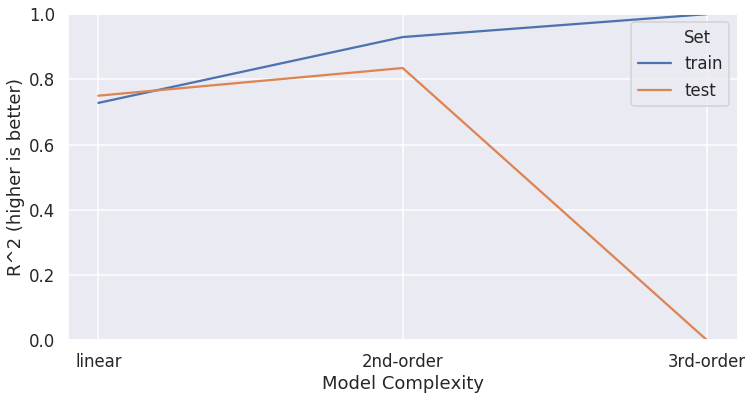

In [244]:
# Show performance of all models on train and test set
df = pd.DataFrame({'Model Complexity': ['linear', 'linear', '2nd-order', '2nd-order', '3rd-order', '3rd-order'],
                  'R^2': [r2_train, r2_test, r2poly_train, r2poly_test, r2poly3_train, r2poly3_test],
                  'Set': ['train', 'test', 'train', 'test', 'train', 'test']})
df['R^2'] = df['R^2'].clip(lower=0)    # Threshold minimum R^2 to 0 for nicer display of results (if it's 0, we already know it learned nothing)

plt.figure(figsize=(12, 6))
sns.lineplot(x='Model Complexity', y='R^2', hue='Set', data=df, sort=False)
plt.ylim(ymin=0, ymax=1)
plt.ylabel('R^2 (higher is better)')
plt.show()

## Sampling bias
- In machine learning, remember that the model just learns patterns in the data you give it
- What if our dataset isn't representative of the type of data we want our model to handle afterwards?
- Most machine learning models fail dramatically for **out of distribution** data that is very different from what we've trained on

<!--
import numpy as np
plt.figure(figsize=(16, 8))
noise = np.random.normal(scale=0.07, size=1000)
x = np.linspace(1, 10, 1000)
y = np.log(x)
samples = y[400:600] + noise[400:600]
plt.plot(x, y, label='true distribution')
plt.scatter(x[400:600], samples, color='r', alpha=0.5, s=20, label='data')
plt.plot(x, x * 1/x[500] + (y[500] - 1), label='model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('images/sampling_bias.png', dpi=200)
plt.show()
-->
<img src="images/sampling_bias.png" style="width: 1200px;"/>

### Activity
Think of a **dataset** and machine learning **task** where:
- Our data was collected within a certain distribution (e.g. house prices in Toronto)
- We evaluate it on out of distribution data where it would fail (e.g. house prices in Tokyo)

Essentially **all** datasets are biased one way or another. Train yourself to think of different ways
that they could be biased and different reasons why. Understanding the conditions under which your model
will work and fail is essential when deploying it in the real world.

*Try and think creatively about real scenarios where the dataset would be biased because of where it came from!
(e.g. don't just say it only had house prices from Toronto, give a realistic explanation for why that might happen)*

<!--
- Houses within a certain age
- Old dataset from another decade
- One data-source (e.g. Creg's list). Very common problem which will cause bias from multiple sources. Instagram selfie example from ModiFace
- Different data processing (e.g. you forget to standardize the new data coming in like you did with your training data)
- Different data formats or devices. For images, different cameras. For audio, different microphones. For text, different writing medium
- Dataset too small (most common problem, since statistically small dataset is bound to be biased). Problem gets worse the more features we have
-->

## Cross-validation
- We wish to evaluate our model on a dataset with little sampling bias, so that we know how it will perform in the real world
- Smaller datasets are far more likely to suffer from sampling bias
- This creates a conflict:
    - We want to have a big test set to get a realistic estimate of our model's performance without sampling bias
    - We want to have a big training set so that our model can learn without sampling bias
- How can we reconcile these goals?

<img src="images/cross_validation.png" style="width: 1000px;"/>

### Cross-validation example

In [245]:
# Make the folds
k_folds = 5

X_folds, y_folds = np.array_split(X, k_folds), np.array_split(y, k_folds)

fold_sizes = ', '.join([str(len(f)) for f in X_folds])
print(f'The folds are of type {type(X_folds)} and contain {fold_sizes} data points')

The folds are of type <class 'list'> and contain 102, 101, 101, 101, 101 data points


In [273]:
# List that will accumulate test performance on each fold
cv_r2 = []

for i in range(k_folds):
    # Make the train/test set for this fold
    X_test = X_folds[i]
    y_test = y_folds[i]
    X_train = [X_folds[j] for j in range(k_folds) if j != i]
    y_train = [y_folds[j] for j in range(k_folds) if j != i]
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    # Train the model
    reg.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    cv_r2.append(r2)
    
print(cv_r2)

[0.7057189451172954, 0.6566041936444876, 0.720302685252295, 0.7898705155348583, 0.7287877060675562]


In [274]:
# Get the mean and standard deviation of the cross-validation test set performance across folds
cv_r2 = np.array(cv_r2)
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.7202568091232985
Std.:	0.04285289109219586


#### Debrief
Notice that this test set performance is actually lower than in our initial example when we split the
dataset once into a train/test set. We should trust this estimate more, because it was computed
from 5 different train/test splits rather than a single one.

#### sklearn provides an easier way to do cross-validation

In [275]:
from sklearn.model_selection import KFold

# List that will accumulate test performance on each fold
cv_r2 = []

kf = KFold(n_splits=k_folds)

for train_idx, test_idx in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    
    # Train the model
    reg.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    cv_r2.append(r2)
    
# Get the mean and standard deviation of the cross-validation test set performance across folds
cv_r2 = np.array(cv_r2)
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.7202568091232985
Std.:	0.04285289109219586


#### And sklearn provides an even easier way if all we're interested in is the scores

In [277]:
from sklearn.model_selection import cross_val_score

cv_r2 = cross_val_score(reg, X, y, cv=k_folds, scoring='r2')
print(f'Cross-validated R^2\nMean:\t{cv_r2.mean()}\nStd.:\t{cv_r2.std()}')

Cross-validated R^2
Mean:	0.7202568091232985
Std.:	0.04285289109219586


### What to do after corss-validation?
**Question**: Cross-validation will give us a more robust estimate of the true out of sample error. However, we have ended up training several models. Which do we pick to finally deploy?

**Answer**: None of them! Cross-validation has served its purpose by giving us a robust estimate of how our model will perform out in the real world. Now, we train our model on the entire dataset, since more data almost always means a better model.

## Hyperparameter tuning
- Most models often have parameters that we must set, which are not learned during training. We call these **hyperparameters**
- For instance, Ridge Regression, which uses L2 regularization to prevent overfitting, requires us to set a λ parameter that balances the weight penalty vs. prediction error in the loss term
- If these hyperparameters are not learned during training, how do we learn them?
- The most common method amounts to, disappointingly, guess-and-check... We try a bunch of values for the hyperparameters and set them to whatever achieves the lowest loss

### Grid search with cross-validation
- 

### Grid search with cross-validation example

### Train/validation/test split
**Question**: Have you noticed anything wrong with what we are doing? Should we trust our cross-validation score as a true estimate of performance on out-of-sample data?

**Answer**: No, we cannot trust it. We have been using the cross-validation score to select hyperparameters. You can think of this as having used the validation data in each fold to train our model in a way. So, our model will be biased to the dataset and our cross-validation score will be overly-optimistic.

**Solution**:
1. Split the dataset into a train/test set
2. Perform grid search with cross-validation on the training set. Each fold, the training set will be split into a train/validation set
3. Using the hyperparameters that obtained the best cross-validation score, retrain the model on the entire training set (not just training folds within this training set)
4. Evaluate the model on the test set to get a true estimate of the out-of-sample error

<img src="images/cross_validation_with_test.png" style="width: 1000px;"/>

*Note*: Instead of splitting the dataset into a train/test set once and doing cross-validation on that single train set, we can perform a nested cross-validation. This gives us an even better estimate of how well our model, training scheme, and hyperparameter search scheme will perform out in the real world. See [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html) for an example.